In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_base_dir = '../../../../datasets/Movielens/'
data_dir = data_base_dir + 'serendipity-sac2018/'
data_dir2 = data_base_dir + 'ml-20m/'
output_dir = data_dir + 'output/'

# genome_scores = data_dir + 'genome_scores.csv'
genome_scores = data_dir + 'tag_genome.csv'
# genome_tags = data_dir + 'genome-tags.csv'
movies = data_dir + 'movies.csv'
# ratings = data_dir + 'ratings.csv'
ratings = data_dir + 'training.csv'
# tags = data_dir + 'tags.csv'
answers = data_dir + 'answers.csv'
genre_binary_terms = output_dir + 'movie_genre_binary_term_vector_df_bz2'
movies_lemmatized = output_dir + 'movies_lemmatized_genome_vector_df_bz2'

answers_df = pd.read_csv(answers)

# data loading and preprocessing
genome_scores_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId',
                                                    values='relevance')
movies_with_genome = genome_scores_df.index.values
# movies_with_genome

movies_df = pd.read_csv(movies)
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']
movies_df = movies_df[movies_df['movieId'].isin(movies_with_genome)]

all_movie_ids = movies_df['movieId'].unique()

ratings_df = pd.read_csv(ratings)
ratings_df = ratings_df[ratings_df['movieId'].isin(all_movie_ids)]
ratings_df = ratings_df.loc[:, ['userId', 'movieId', 'rating']]

all_user_ids = ratings_df['userId'].unique()

In [2]:
# TODO also filter users only inside recommendations or answers dataframe
count_df = answers_df.groupby('userId').count()
# count_df[count_df['movieId'] == 5]
all_answers_user_ids = count_df[count_df['movieId'] == 5].index.values

In [3]:
from sklearn.metrics import pairwise_distances, mean_absolute_error, mean_squared_error


class ContentBased_Recommender:
    def __init__(self, term_vector_df, ratings_df, K=5, metric='cosine', weighted=True):
        self.term_vector_df = term_vector_df
        self.K = K
        self.ratings_df = ratings_df
        self.weighted = weighted

        # preprocessing and other calculations
        self.term_vector_df.fillna(0, inplace=True)
        self.movie_movie_distances = pd.DataFrame(
            pairwise_distances(self.term_vector_df, metric=metric), index=self.term_vector_df.index,
            columns=self.term_vector_df.index)

    def get_mae_mse(self, user_id, candidate_movie_id, user_movies):
        # movies watched by user
        #         if user_movies is None:
        #             user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        # hide candidate movie from the user
        user_movies = np.setdiff1d(user_movies, candidate_movie_id)

        # load user rating for watched movies other than the candidate movie
        # user_ratings =
        users_all_ratings_df = ratings_df[ratings_df['userId'] == user_id]
        users_all_ratings_df = users_all_ratings_df[
            users_all_ratings_df['movieId'].isin(user_movies)]

        # load similarities to the candidate movie
        users_all_ratings_df['sim_candidate_movie'] = self.movie_movie_distances.loc[
            candidate_movie_id, users_all_ratings_df['movieId']].values

        mae, mse = self.predict_ratings_and_get_mae_mse(user_id, candidate_movie_id,
                                                        users_all_ratings_df)

        return mae, mse

    def predict_ratings_and_get_mae_mse(self, user_id, candidate_movie_id, users_all_ratings_df):
        user_ratings = users_all_ratings_df['rating'].values[:self.K]
        similarities = users_all_ratings_df['sim_candidate_movie'].values[:self.K]

        predicted_rating = 0
        if self.weighted:
            # weighted average
            predicted_rating = np.sum(user_ratings * similarities) / np.sum(similarities)
        else:
            # non-weighted average
            predicted_rating = np.sum(user_ratings) / len(user_ratings)

        actual_rating = self.ratings_df[(self.ratings_df['userId'] == user_id) & (
                self.ratings_df['movieId'] == candidate_movie_id)]['rating'].values[0]

        if np.isnan(predicted_rating):
            #             predicted_rating = 0
            predicted_rating = actual_rating

        mae = mean_absolute_error([actual_rating], [predicted_rating])
        mse = mean_squared_error([actual_rating], [predicted_rating])

        return mae, mse

    def get_average_mae_mse(self, user_id, user_movies):
        # movies watched by user
        #         if user_movies is None:
        #             user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        mae_list = list()
        mse_list = list()

        for candidate_movie_id in user_movies:
            mae, mse = self.get_mae_mse(user_id, candidate_movie_id, user_movies)

            mae_list.append(mae)
            mse_list.append(mse)

        return np.median(np.array(mae_list)), np.median(np.array(mse_list))

In [4]:
l1 = 'movies_lemmatized_threshold_'
l2 = '_float_movie_genomes_bz2'

# threshold_0.2_float_movie_genomes_bz2
l3 = 'threshold_'
l4 = '_float_movie_genomes_bz2'

thresholds = [0.25, 0.4, 0.7]
# thresholds = [0.25]

lemmatized_labels = [(l1 + str(x) + l2) for x in thresholds]
lemmatized_labels

full_labels = [(l3 + str(x) + l4) for x in thresholds]
full_labels

['threshold_0.25_float_movie_genomes_bz2',
 'threshold_0.4_float_movie_genomes_bz2',
 'threshold_0.7_float_movie_genomes_bz2']

In [5]:
# loading all required data
user_full_genome_terms_df = pd.read_pickle(output_dir + 'user_full_genome_terms_df_bz2',
                                           compression='bz2')
user_full_genome_terms_gzip_df = pd.read_pickle(output_dir + 'user_full_genome_terms_df_gzip',
                                                compression='bz2')

lemmatized_thresholded_dfs = list()
full_thresholded_dfs = list()

for i, t in enumerate(thresholds):
    lemmatized_thresholded_dfs.append(
        pd.read_pickle(output_dir + lemmatized_labels[i], compression='bz2'))
    full_thresholded_dfs.append(
        pd.read_pickle(output_dir + full_labels[i], compression='bz2'))

In [6]:
# load term vectors
genre_binary_terms_df = pd.read_pickle(genre_binary_terms, compression='bz2')
movies_lemmatized_df = pd.read_pickle(movies_lemmatized, compression='bz2')

In [7]:
import matplotlib.pyplot as plt
from time import time
import warnings

warnings.filterwarnings('ignore')

labels = ['genre_binary', 'genome_full', 'genome_lemmatized']
all_movie_ids = genre_binary_terms_df.index.values


def run(index, K, start_range, end_range):
    #     for index, K in enumerate(K_ranges):
    genre_recommender = ContentBased_Recommender(genre_binary_terms_df, ratings_df, K,
                                                 metric='jaccard', weighted=True)
    genome_full_recommender = ContentBased_Recommender(genome_scores_df, ratings_df, K,
                                                       metric='cosine', weighted=True)
    genome_lemmatized_recommender = ContentBased_Recommender(movies_lemmatized_df, ratings_df, K,
                                                             metric='cosine', weighted=True)

    lemmatized_recommenders = list()
    full_recommenders = list()

    for i, t in enumerate(thresholds):
        full_recommenders.append(
            ContentBased_Recommender(full_thresholded_dfs[i], ratings_df, K, weighted=True))
        lemmatized_recommenders.append(
            ContentBased_Recommender(lemmatized_thresholded_dfs[i], ratings_df, K, weighted=True))

    # mae lists
    genre_mae_list = list()
    genome_full_mae_list = list()
    genome_lemmatized_mae_list = list()

    lemmatized_mae_list = list()
    full_mae_list = list()

    # mse lists
    genre_mse_list = list()
    genome_full_mse_list = list()
    genome_lemmatized_mse_list = list()

    lemmatized_mse_list = list()
    full_mse_list = list()

    for user_id in all_answers_user_ids[start_range:end_range]:
        start_time = time()
        print('user_id', user_id)

        # movies watched by user
        user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        if len(user_movies) <= 1:
            continue

        mae, mse = genre_recommender.get_average_mae_mse(user_id, user_movies)
        genre_mae_list.append(mae)
        genre_mse_list.append(mse)

        mae, mse = genome_full_recommender.get_average_mae_mse(user_id, user_movies)
        genome_full_mae_list.append(mae)
        genome_full_mse_list.append(mse)

        mae, mse = genome_lemmatized_recommender.get_average_mae_mse(user_id, user_movies)
        genome_lemmatized_mae_list.append(mae)
        genome_lemmatized_mse_list.append(mse)

        for i, t in enumerate(thresholds):
            mae, mse = full_recommenders[i].get_average_mae_mse(user_id, user_movies)
            full_mae_list.append(mae)
            full_mse_list.append(mse)

            mae, mse = lemmatized_recommenders[i].get_average_mae_mse(user_id, user_movies)
            lemmatized_mae_list.append(mae)
            lemmatized_mse_list.append(mse)

        finish_time = time() - start_time
        print("Total time taken for this user: %f seconds" % finish_time)

    mae_df = pd.DataFrame()
    mae_df['genre_MAE'] = genre_mae_list
    mae_df['genome_full_MAE'] = genome_full_mae_list
    mae_df['genome_lemmatized_MAE'] = genome_lemmatized_mae_list

    mse_df = pd.DataFrame()
    mse_df['genre_MSE'] = genre_mse_list
    mse_df['genome_full_MSE'] = genome_full_mse_list
    mse_df['genome_lemmatized_MSE'] = genome_lemmatized_mse_list

    for i, t in enumerate(thresholds):
        mae_df[full_labels[i] + '_MAE'] = full_mae_list[i]
        mse_df[full_labels[i] + '_MSE'] = full_mse_list[i]

        mae_df[lemmatized_labels[i] + '_MAE'] = lemmatized_mae_list[i]
        mse_df[lemmatized_labels[i] + '_MSE'] = lemmatized_mse_list[i]

    print("")
    mae_df.median().plot(kind='barh',
                         title='K=' + str(K) + ', avg MAE across all users, for all movies')
    plt.show()
    mse_df.median().plot(kind='barh',
                         title='K=' + str(K) + ', avg MSE across all users, for all movies')
    plt.show()


import multiprocessing as mp
import matplotlib.pyplot as plt

def run_parallel_for_users_range(start_range, end_range, K_ranges):
    # K_ranges = [5, 10, 15, 20, 30, 40, 50]
#     K_ranges = [5, 10, 15, 20]
    # K_ranges = [5]

#     start_range = 0
#     end_range = len(all_answers_user_ids)

    p_list = list()
    for index, K in enumerate(K_ranges):
        p = mp.Process(target=run, args=(index, K,start_range, end_range,))
        p_list.append(p)
        p.start()

#     for p in p_list:
#         # wait until all processes are finished
#         p.join()

    print("main process")

main process
user_id 100200
user_id 100200
user_id 100200
user_id 100200
Total time taken for this user: 16.000369 seconds
user_id 100269
Total time taken for this user: 16.091713 seconds
user_id 100269
Total time taken for this user: 16.014804 seconds
user_id 100269
Total time taken for this user: 15.944885 seconds
user_id 100269
Total time taken for this user: 30.432440 seconds
user_id 100521
Total time taken for this user: 30.450430 seconds
user_id 100521
Total time taken for this user: 30.615985 seconds
user_id 100521
Total time taken for this user: 30.688583 seconds
user_id 100521
Total time taken for this user: 18.425701 seconds
user_id 100972
Total time taken for this user: 18.520668 seconds
user_id 100972
Total time taken for this user: 18.412320 seconds
user_id 100972
Total time taken for this user: 18.399555 seconds
user_id 100972
Total time taken for this user: 16.926775 seconds
user_id 100998
Total time taken for this user: 16.915002 seconds
user_id 100998
Total time taken 

user_id 109086
Total time taken for this user: 6.591230 seconds
user_id 109086
Total time taken for this user: 6.646938 seconds
user_id 109086
Total time taken for this user: 6.070939 seconds
user_id 109135
Total time taken for this user: 6.086823 seconds
user_id 109135
Total time taken for this user: 6.085739 seconds
user_id 109135
Total time taken for this user: 6.027700 seconds
user_id 109135
Total time taken for this user: 11.133094 seconds
user_id 109289
Total time taken for this user: 11.025801 seconds
user_id 109289
Total time taken for this user: 11.010058 seconds
user_id 109289
Total time taken for this user: 11.014106 seconds
user_id 109289
Total time taken for this user: 24.150672 seconds
user_id 109335
Total time taken for this user: 24.200012 seconds
user_id 109335
Total time taken for this user: 24.215809 seconds
user_id 109335
Total time taken for this user: 24.131501 seconds
user_id 109335
Total time taken for this user: 9.827643 seconds
user_id 109384
Total time taken 

user_id 113401
Total time taken for this user: 1.165222 seconds
user_id 113591
Total time taken for this user: 1.076512 seconds
user_id 113591
Total time taken for this user: 1.054795 seconds
user_id 113591
Total time taken for this user: 24.939421 seconds
user_id 113673
Total time taken for this user: 25.285656 seconds
user_id 113673
Total time taken for this user: 24.992199 seconds
user_id 113673
Total time taken for this user: 25.078839 seconds
user_id 113673
Total time taken for this user: 41.099895 seconds
user_id 113679
Total time taken for this user: 40.418722 seconds
user_id 113679
Total time taken for this user: 40.452574 seconds
user_id 113679
Total time taken for this user: 40.454279 seconds
user_id 113679
Total time taken for this user: 18.063113 seconds
user_id 113769
Total time taken for this user: 18.048126 seconds
user_id 113769
Total time taken for this user: 18.109226 seconds
user_id 113769
Total time taken for this user: 18.125999 seconds
user_id 113769
Total time ta

user_id 119213
Total time taken for this user: 5.563867 seconds
user_id 119300
Total time taken for this user: 5.408658 seconds
user_id 119300
Total time taken for this user: 5.416323 seconds
user_id 119300
Total time taken for this user: 5.437571 seconds
user_id 119300
Total time taken for this user: 3.635638 seconds
user_id 119327
Total time taken for this user: 3.663395 seconds
user_id 119327
Total time taken for this user: 3.621609 seconds
user_id 119327
Total time taken for this user: 3.608203 seconds
user_id 119327
Total time taken for this user: 2.601266 seconds
user_id 119422
Total time taken for this user: 2.636147 seconds
user_id 119422
Total time taken for this user: 2.676629 seconds
Total time taken for this user: 2.668830 seconds
user_id 119422
user_id 119422
Total time taken for this user: 17.138622 seconds
user_id 119489
Total time taken for this user: 17.118025 seconds
user_id 119489
Total time taken for this user: 17.124568 seconds
user_id 119489
Total time taken for t

user_id 123384
Total time taken for this user: 6.745901 seconds
user_id 123384
Total time taken for this user: 12.241659 seconds
user_id 123493
Total time taken for this user: 12.239529 seconds
user_id 123493
Total time taken for this user: 12.273422 seconds
user_id 123493
Total time taken for this user: 12.301443 seconds
user_id 123493
Total time taken for this user: 19.547692 seconds
user_id 123593
Total time taken for this user: 19.466126 seconds
user_id 123593
Total time taken for this user: 19.551375 seconds
user_id 123593
Total time taken for this user: 19.482846 seconds
user_id 123593
Total time taken for this user: 42.436340 seconds
user_id 123637
Total time taken for this user: 42.393539 seconds
user_id 123637
Total time taken for this user: 42.539112 seconds
user_id 123637
Total time taken for this user: 42.496159 seconds
user_id 123637
Total time taken for this user: 27.445750 seconds
user_id 123708
Total time taken for this user: 27.442929 seconds
Total time taken for this 

user_id 127031
Total time taken for this user: 18.594386 seconds
user_id 127031
Total time taken for this user: 18.523489 seconds
user_id 127031
Total time taken for this user: 2.799812 seconds
user_id 127361
Total time taken for this user: 2.716036 seconds
user_id 127361
Total time taken for this user: 2.713897 seconds
user_id 127361
Total time taken for this user: 2.706599 seconds
user_id 127361
Total time taken for this user: 6.694401 seconds
user_id 127480
Total time taken for this user: 6.552932 seconds
user_id 127480
Total time taken for this user: 6.566156 seconds
user_id 127480
Total time taken for this user: 6.655478 seconds
user_id 127480
Total time taken for this user: 2.792681 seconds
user_id 127669
Total time taken for this user: 2.762342 seconds
user_id 127669
Total time taken for this user: 2.767514 seconds
user_id 127669
Total time taken for this user: 2.816614 seconds
user_id 127669
Total time taken for this user: 8.318387 seconds
user_id 127845
Total time taken for th

user_id 133132
Total time taken for this user: 12.434767 seconds
user_id 133132
Total time taken for this user: 12.184731 seconds
user_id 133132
Total time taken for this user: 12.472654 seconds
user_id 133132
Total time taken for this user: 3.413819 seconds
user_id 134005
Total time taken for this user: 3.401616 seconds
user_id 134005
Total time taken for this user: 3.382753 seconds
user_id 134005
Total time taken for this user: 3.375688 seconds
user_id 134005
Total time taken for this user: 5.377993 seconds
user_id 139429
Total time taken for this user: 5.365405 seconds
user_id 139429
Total time taken for this user: 5.345262 seconds
user_id 139429
Total time taken for this user: 5.326079 seconds
user_id 139429
Total time taken for this user: 3.803163 seconds
user_id 140928
user_id 141690
Total time taken for this user: 3.935319 seconds
user_id 140928
user_id 141690
Total time taken for this user: 4.059390 seconds
user_id 140928
user_id 141690
Total time taken for this user: 4.136997 

user_id 143883
Total time taken for this user: 12.020305 seconds
user_id 143883
Total time taken for this user: 12.000848 seconds
user_id 143883
Total time taken for this user: 3.734780 seconds
user_id 143909
Total time taken for this user: 3.770187 seconds
user_id 143909
Total time taken for this user: 3.640952 seconds
user_id 143909
Total time taken for this user: 3.625244 seconds
user_id 143909
Total time taken for this user: 9.873409 seconds
user_id 143912
Total time taken for this user: 9.984119 seconds
user_id 143912
Total time taken for this user: 10.054922 seconds
user_id 143912
Total time taken for this user: 10.103199 seconds
user_id 143912
Total time taken for this user: 5.107311 seconds
user_id 143935
Total time taken for this user: 5.124434 seconds
user_id 143935
Total time taken for this user: 5.186461 seconds
user_id 143935
Total time taken for this user: 2.099369 seconds
user_id 143945
Total time taken for this user: 5.100489 seconds
user_id 143935
Total time taken for 

Total time taken for this user: 4.475975 seconds
user_id 145613
Total time taken for this user: 4.371925 seconds
user_id 145613
Total time taken for this user: 4.346433 seconds
user_id 145675
Total time taken for this user: 4.433048 seconds
user_id 145613
Total time taken for this user: 4.911781 seconds
user_id 145675
Total time taken for this user: 3.886306 seconds
user_id 145687
Total time taken for this user: 5.168292 seconds
user_id 145675
Total time taken for this user: 4.492114 seconds
user_id 145675
Total time taken for this user: 4.460737 seconds
user_id 145687
Total time taken for this user: 4.146800 seconds
user_id 145687
Total time taken for this user: 4.250324 seconds
user_id 145687
Total time taken for this user: 7.898508 seconds
user_id 145764
Total time taken for this user: 2.256958 seconds
user_id 145865
Total time taken for this user: 8.988494 seconds
user_id 145764
Total time taken for this user: 7.434518 seconds
user_id 145764
Total time taken for this user: 8.224158

user_id 157411
Total time taken for this user: 24.217416 seconds
user_id 157411
Total time taken for this user: 24.044676 seconds
user_id 157411
Total time taken for this user: 24.101780 seconds
user_id 157411
Total time taken for this user: 31.802283 seconds
user_id 158969
Total time taken for this user: 31.448265 seconds
user_id 158969
Total time taken for this user: 31.545738 seconds
user_id 158969
Total time taken for this user: 31.196747 seconds
user_id 158969
Total time taken for this user: 32.253679 seconds
user_id 159140
Total time taken for this user: 32.049060 seconds
user_id 159140
Total time taken for this user: 32.195693 seconds
user_id 159140
Total time taken for this user: 32.047729 seconds
user_id 159140
Total time taken for this user: 20.300234 seconds
user_id 159426
Total time taken for this user: 20.314689 seconds
user_id 159426
Total time taken for this user: 20.461886 seconds
user_id 159426
Total time taken for this user: 20.243559 seconds
user_id 159426
Total time

user_id 190450
Total time taken for this user: 17.718585 seconds
user_id 191484
Total time taken for this user: 17.790263 seconds
user_id 191484
Total time taken for this user: 17.923642 seconds
user_id 191484
Total time taken for this user: 17.864652 seconds
user_id 191484
Total time taken for this user: 6.784982 seconds
user_id 192643
Total time taken for this user: 6.890058 seconds
user_id 192643
Total time taken for this user: 6.846214 seconds
user_id 192643
Total time taken for this user: 6.829580 seconds
user_id 192643
Total time taken for this user: 6.858753 seconds
user_id 192730
Total time taken for this user: 6.782413 seconds
user_id 192730
Total time taken for this user: 6.825616 seconds
user_id 192730
Total time taken for this user: 6.856675 seconds
user_id 192730
Total time taken for this user: 19.563666 seconds
user_id 194785
Total time taken for this user: 19.615225 seconds
user_id 194785
Total time taken for this user: 19.584416 seconds
user_id 194785
Total time taken f

user_id 201672
Total time taken for this user: 43.339343 seconds
user_id 201672
Total time taken for this user: 19.161046 seconds
user_id 201960
Total time taken for this user: 18.019702 seconds
user_id 201960
Total time taken for this user: 17.834350 seconds
user_id 201960
Total time taken for this user: 17.795609 seconds
user_id 201960
Total time taken for this user: 14.206827 seconds
user_id 202808
Total time taken for this user: 13.652686 seconds
user_id 202808
Total time taken for this user: 13.568925 seconds
user_id 202808
Total time taken for this user: 13.653105 seconds
user_id 202808
Total time taken for this user: 16.135559 seconds
user_id 202953
Total time taken for this user: 16.056790 seconds
user_id 202953
Total time taken for this user: 16.139614 seconds
user_id 202953
Total time taken for this user: 16.178302 seconds
user_id 202953
Total time taken for this user: 13.643804 seconds
user_id 203571
Total time taken for this user: 13.612552 seconds
user_id 203571
Total time

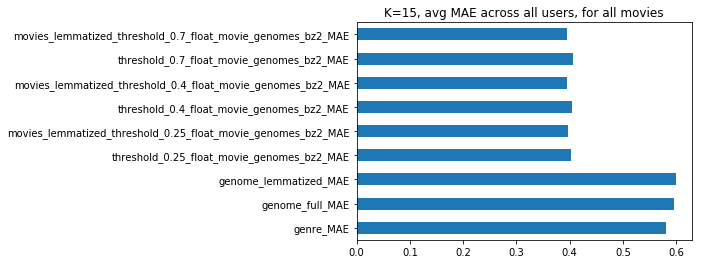

Total time taken for this user: 10.586489 seconds



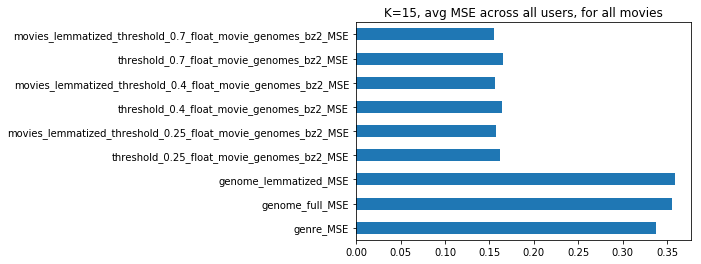

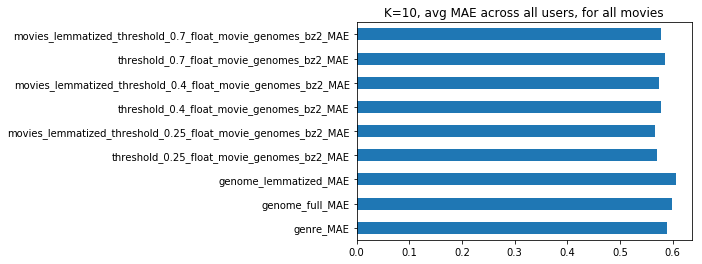

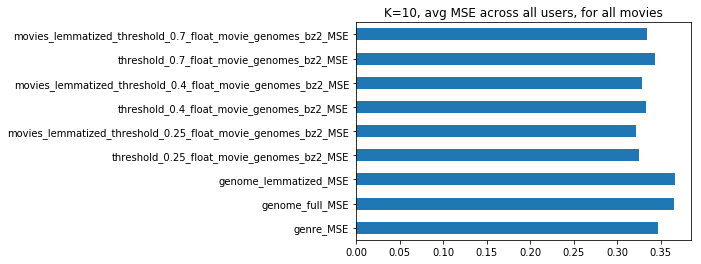

Total time taken for this user: 10.357383 seconds



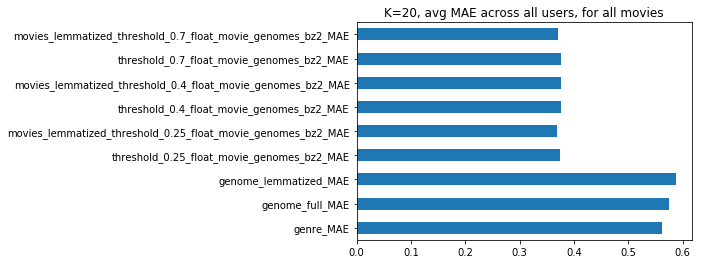

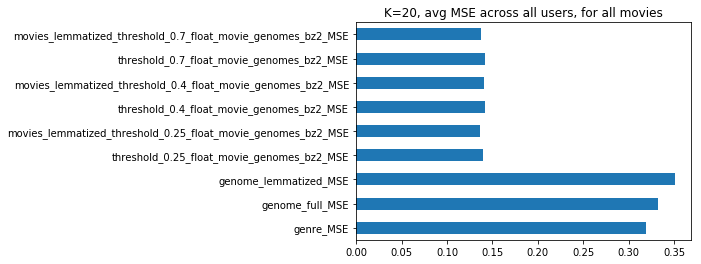

Total time taken for this user: 10.271660 seconds



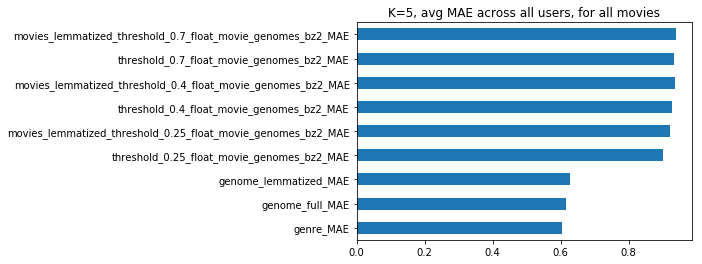

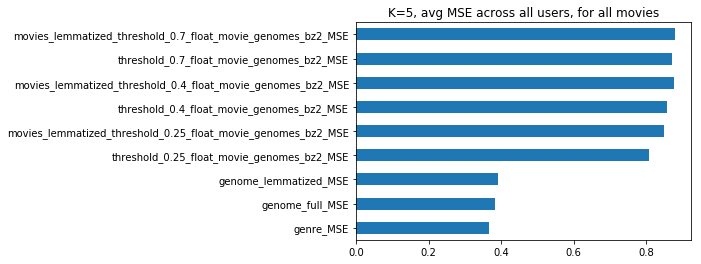

In [9]:
K_ranges = [5, 10, 15, 20]
start_range = 0
end_range = len(all_answers_user_ids)
# end_range = 5
run_parallel_for_users_range(start_range, end_range, K_ranges)

In [56]:
user_id = 206808
print('Progress %.2f%%' % ((np.where(all_answers_user_ids == user_id)[0][0]/(all_answers_user_ids.size - 1)) * 100))

Progress 100.00%


main process
user_id 101049
user_id 101049
Total time taken for this user: 6.135335 seconds
user_id 101170
Total time taken for this user: 6.253494 seconds
user_id 101170
Total time taken for this user: 54.449054 seconds
user_id 101263
Total time taken for this user: 54.813672 seconds
user_id 101263
Total time taken for this user: 14.066595 seconds
user_id 101579
Total time taken for this user: 14.253590 seconds
user_id 101579
Total time taken for this user: 12.105224 seconds
user_id 101721
Total time taken for this user: 12.129432 seconds
user_id 101721
Total time taken for this user: 18.849368 seconds
user_id 101743
Total time taken for this user: 19.160431 seconds
user_id 101743
Total time taken for this user: 22.739281 seconds



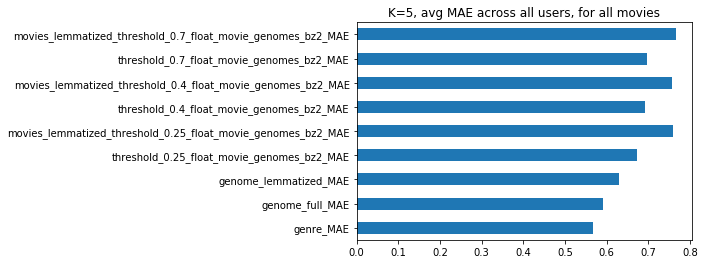

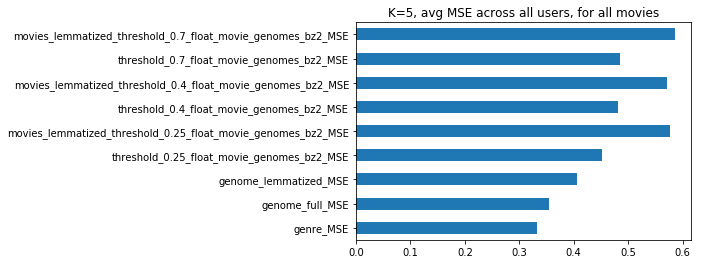

Total time taken for this user: 22.444452 seconds



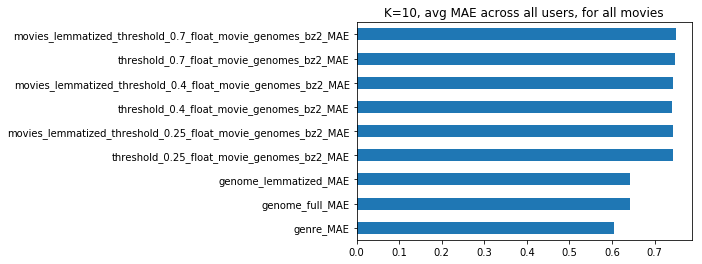

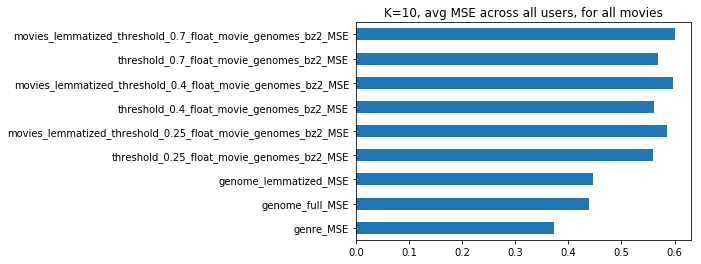

In [15]:
# K_ranges = [5, 10]
# start_range = 5
# # end_range = len(all_answers_user_ids)
# end_range = 11
# run_parallel_for_users_range(start_range, end_range, K_ranges)